In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kaggle/meta-kaggle-code")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/meta-kaggle-code


In [3]:
1

1

In [ ]:
import os
import re
import json
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor, as_completed


# 🔍 Extract imports from code text
def extract_imports_from_code(code):
    pattern = r'(?:import|from)\s+([a-zA-Z0-9_\.]+)'
    matches = re.findall(pattern, code)
    libraries = {match.split('.')[0] for match in matches}
    return libraries


# 📓 Extract imports from .ipynb notebook
def extract_imports_from_ipynb(file_path):
    imports = set()
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            nb = json.load(f)
            for cell in nb.get('cells', []):
                if cell.get('cell_type') == 'code':
                    full_code = ''.join(cell.get('source', []))
                    imports.update(extract_imports_from_code(full_code))
    except:
        pass
    return imports


# 🐍 Extract imports from .py script
def extract_imports_from_py(file_path):
    imports = set()
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            code = f.read()
            imports.update(extract_imports_from_code(code))
    except:
        pass
    return imports


# 🔧 Process single file
def process_file(file_path):
    if file_path.endswith('.py'):
        imports = extract_imports_from_py(file_path)
    elif file_path.endswith('.ipynb'):
        imports = extract_imports_from_ipynb(file_path)
    else:
        imports = set()
    return {'FilePath': file_path, 'Library': ', '.join(sorted(imports))}


# 📂 Process a folder
def process_folder(folder_path):
    files = []
    for dirpath, _, filenames in os.walk(folder_path):
        for file in filenames:
            if file.endswith('.py') or file.endswith('.ipynb'):
                files.append(os.path.join(dirpath, file))

    results = []
    with ThreadPoolExecutor(max_workers=64) as executor:
        future_to_file = {executor.submit(process_file, file): file for file in files}
        for future in as_completed(future_to_file):
            result = future.result()
            results.append(result)
    return results


# 🚀 Main directory processing
base_root = '/kaggle/input/meta-kaggle-code'
all_results = []

start = time.time()

for main_folder in os.listdir(base_root):
    # start_main = time.time()
    main_folder_path = os.path.join(base_root, main_folder)
    if os.path.isdir(main_folder_path):
        for subfolder in os.listdir(main_folder_path):
            subfolder_path = os.path.join(main_folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                results = process_folder(subfolder_path)
                all_results.extend(results)
    # end_main = time.time()
    # print(end_main-start_time)

# 💾 Save final output
if all_results:
    final_df = pd.DataFrame(all_results)
    final_df.to_csv('/kaggle/working/all_imports.csv', index=False)
    print("✅ All data saved to /kaggle/working/all_imports.csv")
else:
    print("⚠️ No files found.")

end = time.time()
print(f"⏳ Total time taken: {end - start:.2f} seconds")

In [24]:
final_df.head()

,FilePath,Library
0,/kaggle/input/meta-kaggle-code/0111/437/111437...,pandas
1,/kaggle/input/meta-kaggle-code/0111/437/111437...,"DecisionTreeClassifier, RandomForestClassifier..."
2,/kaggle/input/meta-kaggle-code/0111/437/111437...,"matplotlib, numpy, os, pandas, pyplot, seaborn..."
3,/kaggle/input/meta-kaggle-code/0111/437/111437...,"AdaBoostClassifier, Adaboost, AutoKeras, Baggi..."
4,/kaggle/input/meta-kaggle-code/0111/437/111437...,"datetime, init_notebook_mode, matplotlib, nump..."


In [25]:
import pandas as pd

# Split the 'Library' column by comma and explode to separate rows
libraries_series = final_df['Library'].dropna().str.split(',\s*').explode()

# Strip whitespace just in case
libraries_series = libraries_series.str.strip()

# Count occurrences
library_counts = libraries_series.value_counts().reset_index()
library_counts.columns = ['Library', 'Count']

# Display top results
print(library_counts.head(10))

# Save to CSV if needed
library_counts.to_csv('/kaggle/working/library_usage_counts.csv', index=False)

            Library    Count
0            pandas  6444637
1             numpy  6366578
2        matplotlib  4716031
3           sklearn  4143214
4                os  4041768
5           seaborn  2862495
6  train_test_split  2227972
7          warnings  1331745
8        tensorflow  1074869
9    StandardScaler   999856


In [26]:
len(library_counts)

96970

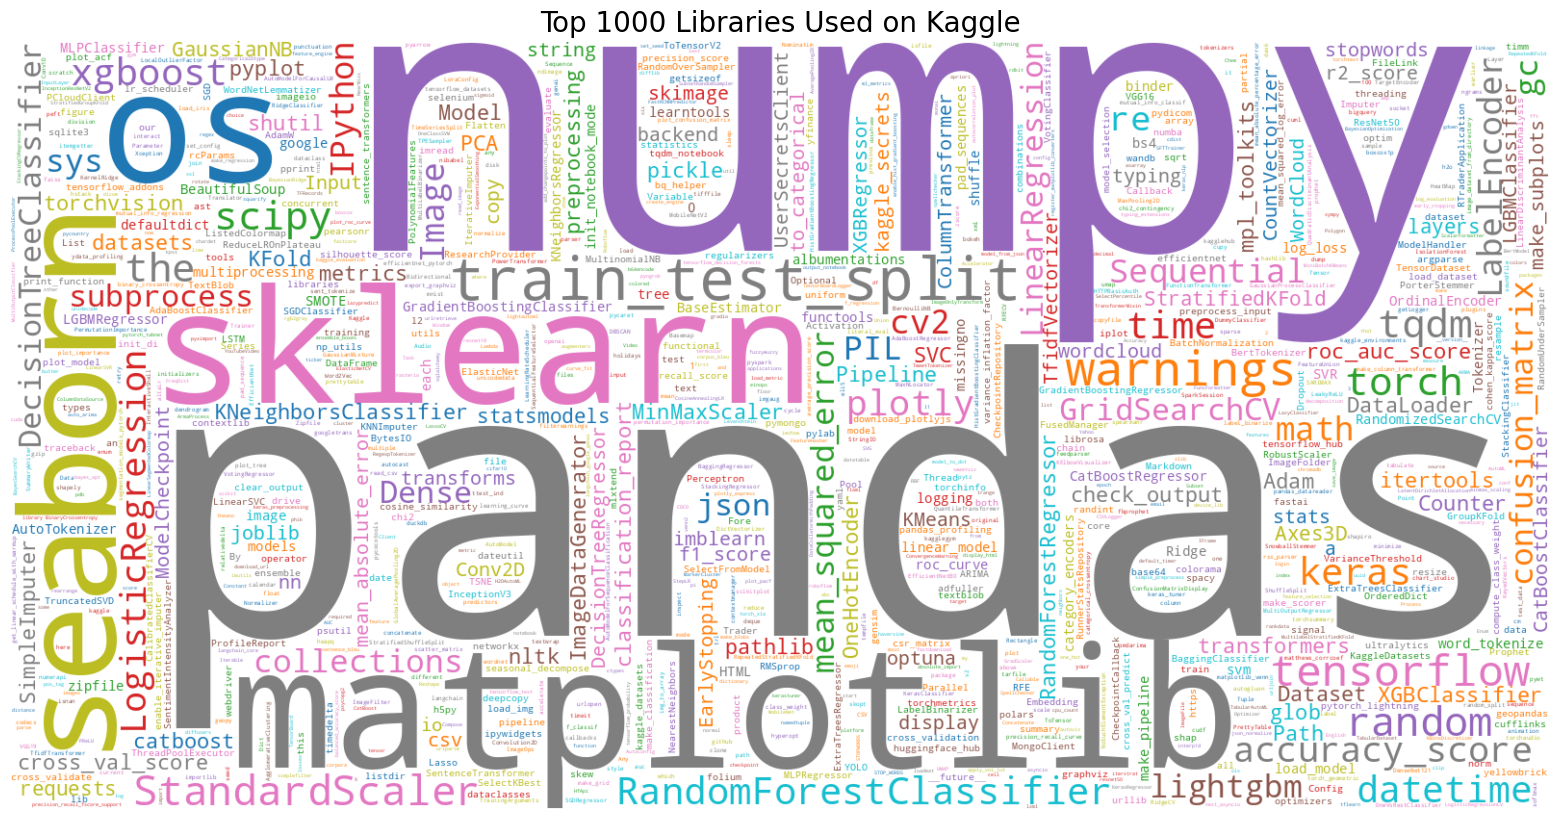

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Prepare frequency dictionary (top 1000)
library_freq = dict(library_counts.head(1000).values)

# Create the WordCloud
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    colormap='tab10',
    max_words=1000
).generate_from_frequencies(library_freq)

# Plot
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 1000 Libraries Used on Kaggle', fontsize=20)
plt.show()

In [28]:
library_counts.head(100)

,Library,Count
0,pandas,6444637
1,numpy,6366578
2,matplotlib,4716031
3,sklearn,4143214
4,os,4041768
...,...,...
95,TfidfVectorizer,180012
96,KMeans,177448
97,to_categorical,174290
98,DecisionTreeRegressor,167638


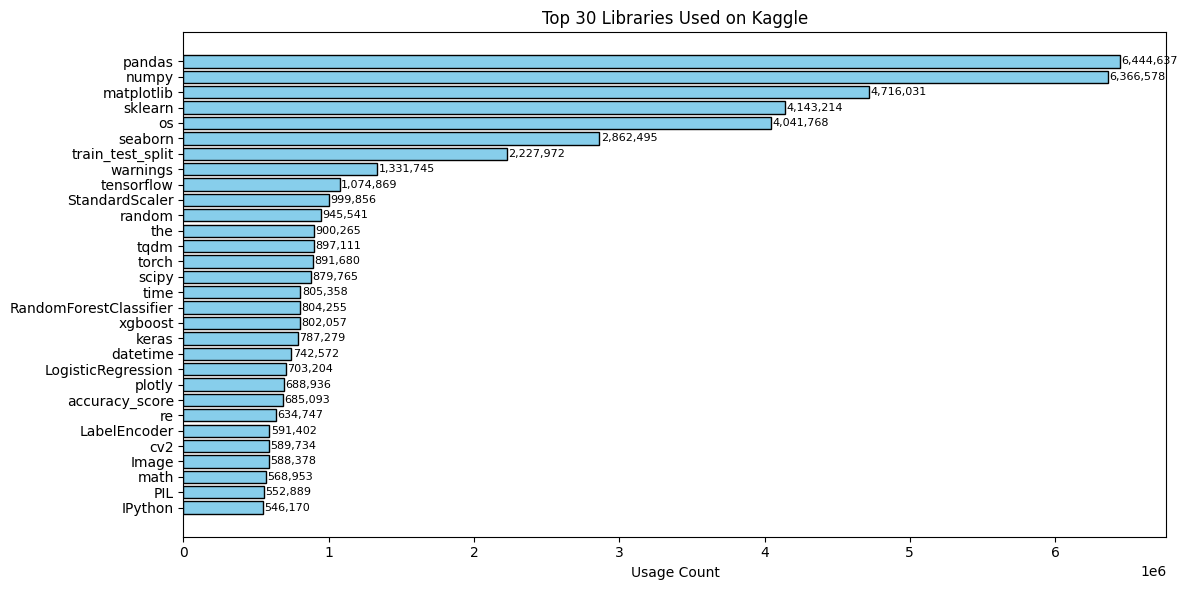

In [29]:
import matplotlib.pyplot as plt

# Sort library counts and pick top 30
top30_libs = library_counts.sort_values('Count', ascending=False).head(30)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.barh(top30_libs['Library'], top30_libs['Count'], color='skyblue', edgecolor='black')
plt.xlabel('Usage Count')
plt.title('Top 30 Libraries Used on Kaggle')

# Annotate counts on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 10000, bar.get_y() + bar.get_height() / 2, f'{int(width):,}', va='center', fontsize=8)

plt.gca().invert_yaxis()  # Largest at top
plt.tight_layout()
plt.show()